# Text Processing on Haptik Dataset

## The challenge

#### The domain classification challenge from Haptik Open Datasets: Classify (short) user queries into one of the given nine classes. 
#### Expected Performance.
#### Suggested metric: Overall Accuracy/Subset Accuracy
#### Baseline Performance: 70%
#### Expected Performance: >80%

In [16]:
#future imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Data Cleaning packages
from pandas import read_csv, Series, DataFrame
from numpy import array, ravel
from nltk.tokenize import TreebankWordTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import operator
import copy
from collections import OrderedDict
from string import punctuation
import pickle
import os


#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Model package
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#Time
import time   

#Model Fitting
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [17]:
#timeit Decorator
def timeit(method):
    ''' To check the process time
    '''
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [18]:
@timeit
def load_dataset(filepath):
    ''' Loading the Dataset
    '''
    dataset = read_csv(filepath, encoding = 'UTF-8')
    return dataset

train = load_dataset('./train_data.csv')

test = load_dataset('./test_data.csv') 

'load_dataset'  77.23 ms
'load_dataset'  17.36 ms


In [19]:
#separating feature and target variable
@timeit
def feature_target(df):
    ''' Seperating feature and label from the dataset
    '''
    feature = df.iloc[:,0]
    target = df.iloc[:,1:]
    return feature, target

X_train, y_train = feature_target(train)
X_test, y_test = feature_target(test)
# X is the Feature while y is the Label

'feature_target'  0.63 ms
'feature_target'  0.53 ms


In [20]:
X_test.head()

0                                Nearest metro station
1                    Pick up n drop service trough cab
2                                I wants to buy a bick
3                                        Show me pizza
4    What is the cheapest package to andaman and ni...
Name: message, dtype: object

In [21]:
@timeit
def multi_label_binarizer(df):
    """Maps ["T", "F"] to [1, 0] in a given dataframe
    """
    #dfmi.astype(str).applymap(lambda x: '%i' % pd.Series(x).map({'a':0, 'b':1}))
    df = df.astype(str).applymap(lambda x: 1 if x=='T' else 0)
    return df

target = multi_label_binarizer(y_train)
test_target = multi_label_binarizer(y_test)
target.head()

'multi_label_binarizer'  367.35 ms
'multi_label_binarizer'  73.22 ms


,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [22]:
@timeit
def normalized():
    freq = ravel(target.sum(axis = 0))
    freq = dict(zip(target.columns, freq))
    freq = OrderedDict(sorted(freq.items(), key = operator.itemgetter(1)))
    yhist = DataFrame({'label':freq.keys(), 'count':freq.values()})
    yhist['normalized'] = yhist['count']/yhist['count'].sum()
    return yhist

yhist = normalized()

'normalized'  6.20 ms


#### Now we will work on train_feature dataframe and preprocess the data.
#### Following Approach is taken ---
#### 1. Tokenize all the words in the feature variable
#### 2. Remove the Punctuations and stopwords
#### 3. Stem the words to keep the root word

#### We have also created our own list of stopwords to better the accuracy score

In [23]:
#stop word removal 
sw_curated = ['a9c0', 'f0af5ee2b89b', '676951', 'hi', '727893', '55616', 'task_nam',
             'user_id', '50', '16', 'exotel','ok', 'haptik', 'nearbi',
             'api_nam', 'offset', 'user_id', '00', 'pleas', 'can', 'pl',
             'drink_water', 'reminer_list', 'trains_api', 'product_id',
             'I', 'j', 'se', 'sl', '10', 'hai', 'll', 'kya', 'rs', 'sorri',
             'know', '30', 'one', '10 00', 'bu', 'reminder_list',
             'plz', 'everi']


@timeit   
def preprocess(X):
    ''' Preprocessing on the train dataset
    '''
    #create english stop word list
    en_stop = get_stop_words('en')
    stemmer = PorterStemmer()
    tokenize = TreebankWordTokenizer()
    
    X = X.apply(lambda row: row.lower())
    X = X.apply(lambda row: tokenize.tokenize(row)) # do tokenization
    X = X.apply(lambda row: [i for i in row if i not in en_stop]) # remove english stop words
    X = X.apply(lambda row :[i for i in row if i not in punctuation]) #remove punctuation
    X = X.apply(lambda row:[stemmer.stem(word) for word in row])      #porter Stemmer 
    X = X.apply(lambda row: [i for i in row if i not in sw_curated])  #remove sw_curated string from X
    return X

X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_train.head()

'preprocess'  12975.33 ms
'preprocess'  2883.90 ms


0                                [7am, everyday]
1                                 [chocol, cake]
2    [close, mortic, tenon, joint, door, diment]
3                        [train, eppo, kelambum]
4            [yesterday, cancel, flight, ticket]
Name: message, dtype: object

#### Since our machine cannot understand the string variables, we will convert them into sparse matrix form.
#### For our model, we will try using two of the vectorization method.
#### 1. CountVectorizer
#### 2. Tf-IdfVectorizer

In [24]:
# Count Vectorizer
@timeit
def count_vector(X_train, X_test):
    ''' creates matrix using count vectorizer
    '''
    vect = CountVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.5)
    X_train = Series([' '.join(x) for x in X_train])
    X_test = Series([' '.join(x) for x in X_test])
    train_dtm = vect.fit_transform(X_train)
    test_dtm = vect.transform(X_test)
    return train_dtm, test_dtm

In [25]:
@timeit
def tfid_vect(X_train, X_test):
    ''' creates matrix using tfidf vectorizer
    '''
    vect = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.5)
    X_train = Series([' '.join(x) for x in X_train])
    X_test = Series([' '.join(x) for x in X_test])
    vect.fit(X_train)
    train_dtm = vect.transform(X_train)
    test_dtm = vect.transform(X_test)
    return X_train, X_test

In [26]:
def tok_freq_count(X):
    freq = ravel(X.sum(axis=0))
    vocab = [v[0] for v in sorted(vect.vocabulary_.items(), key=operator.itemgetter(1))]
    freq_sorted = dict(zip(vocab, freq))
    freq_dict = OrderedDict(freq_sorted.items(), key=operator.itemgetter(1))
    wordfreq = DataFrame({'word': freq_dict.keys(), 'count': freq_dict.values()})
    return wordfreq

#### After pre-processing, we will plot the wordcloud with the words present and a histogram of the normalized labels.

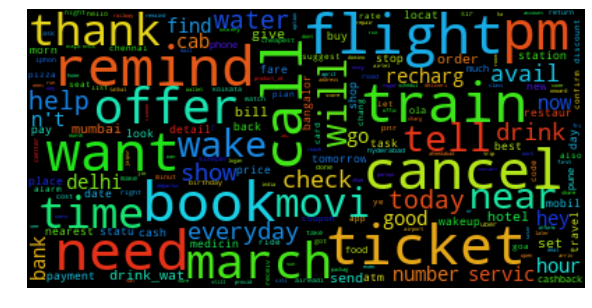

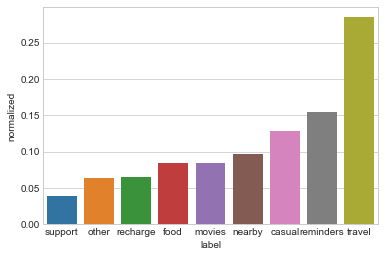

In [27]:
# wordCloud for visualization

def wordCloud(X_train):
    text = []
    for i in range(len(X_train)):
        text = text + [i for i in X_train[i]]
    textall = " ".join(text)
    wordcloud = WordCloud(max_font_size=40).generate(textall)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    return plt.show()

wordCloud(X_train)
    
def yhist_plot(yhist):
    sns.set_style("whitegrid")
    ax = sns.barplot(x="label", y="normalized", data=yhist)
    return plt.show()

yhist_plot(yhist)

In [15]:
print(train_dtm.shape)
print(test_dtm.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

NameError: name 'train_dtm' is not defined

In [ ]:
target.head()

#### Now we will build our model and check the accuracy scores with respect to different models.
#### We will also calculate the label accuracy 

In [ ]:
def label_accuracy(y_true, y_pred):
    """
    Compute label accuracy
    """
    res = (y_true == y_pred)
    return (res).sum().sum()/res.size

In [ ]:
@timeit
def classification(vectorizer, model):
    ''' model fitting and accuracy
    '''
    X_train = copy.deepcopy(train_dtm)
    X_test = copy.deepcopy(test_dtm)
    y_train = copy.deepcopy(target)
    y_test = copy.deepcopy(test_target)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    # Find accuracy metrics
    accuracy_subset = accuracy_score(y_test, prediction)
    accuracy_label = label_accuracy(y_test, prediction)
    c_report = classification_report(y_test, prediction)
    print('accuracy_label: ', accuracy_label)
    print('accuracy_subset: ', accuracy_subset)
    print('classification report: \n', c_report)
    pass



### Iteration 1

In [2]:
clf = classification(vectorizer=count_vector(X_train, X_test), model=OneVsRestClassifier(MultinomialNB()))

def save_model(model, name) :
    ''' Saves the model ran
    '''
    if not os.path.exists('model'):
        os.makedirs('model')    
    save_model = open("model/" + name + ".pickle","wb")
    pickle.dump(model, save_model)
    save_model.close()

save_model(clf,'randomclf')

def import_model(name):
    model_f = open("model/"+name+".pickle", "rb")
    model = pickle.load(model_f)
    model_f.close()
    return model

NameError: name 'classification' is not defined

### Iteration 2

In [58]:
classification(vectorizer=tfid_vect(X_train, X_test), model=RandomForestClassifier(n_estimators=200))

accuracy_label:  0.943911111111
accuracy_subset:  0.727
classification report: 
              precision    recall  f1-score   support

          0       0.78      0.62      0.69       810
          1       0.75      0.70      0.72       450
          2       0.61      0.26      0.37       371
          3       0.84      0.86      0.85       893
          4       0.80      0.85      0.82      2138
          5       0.65      0.59      0.62       807
          6       0.71      0.61      0.65       637
          7       0.84      0.84      0.84      3282
          8       0.92      0.50      0.65      1668

avg / total       0.80      0.72      0.75     11056

'classification'  451563.19 ms


### Iteration 3

In [59]:
#using RandomForestClassifier
classification(vectorizer=count_vector(X_train, X_test), model=RandomForestClassifier(n_estimators=200))

'count_vector'  1500.10 ms
accuracy_label:  0.943844444444
accuracy_subset:  0.7269
classification report: 
              precision    recall  f1-score   support

          0       0.78      0.62      0.69       810
          1       0.74      0.68      0.71       450
          2       0.64      0.27      0.38       371
          3       0.85      0.85      0.85       893
          4       0.79      0.84      0.82      2138
          5       0.65      0.60      0.62       807
          6       0.71      0.61      0.65       637
          7       0.83      0.85      0.84      3282
          8       0.92      0.50      0.65      1668

avg / total       0.81      0.72      0.75     11056

'classification'  442237.89 ms


### Iteration 4

In [61]:
# using randomforest classifier using n_estimators = 200
classification(vectorizer=count_vector(X_train, X_test), model=OneVsRestClassifier(LogisticRegression()))

'count_vector'  1376.73 ms
accuracy_label:  0.9458
accuracy_subset:  0.657
classification report: 
              precision    recall  f1-score   support

          0       0.91      0.57      0.70       810
          1       0.83      0.60      0.70       450
          2       0.84      0.29      0.43       371
          3       0.93      0.79      0.86       893
          4       0.86      0.83      0.84      2138
          5       0.74      0.58      0.65       807
          6       0.90      0.52      0.66       637
          7       0.92      0.62      0.74      3282
          8       0.95      0.55      0.69      1668

avg / total       0.89      0.64      0.74     11056

'classification'  3396.45 ms


### Iteration 5

In [60]:
classification(vectorizer=tfid_vect(X_train, X_test), model=OneVsRestClassifier(LogisticRegression()))

accuracy_label:  0.943777777778
accuracy_subset:  0.7273
classification report: 
              precision    recall  f1-score   support

          0       0.78      0.61      0.69       810
          1       0.75      0.69      0.72       450
          2       0.59      0.26      0.36       371
          3       0.84      0.85      0.85       893
          4       0.79      0.84      0.82      2138
          5       0.65      0.60      0.63       807
          6       0.71      0.61      0.66       637
          7       0.84      0.85      0.84      3282
          8       0.92      0.50      0.65      1668

avg / total       0.80      0.72      0.75     11056

'classification'  429249.65 ms


### Iteration 6

In [68]:
#using multinominalNB with alpha = 0.01
classification(vectorizer=count_vector(X_train, X_test), model=OneVsRestClassifier(SGDClassifier()))

'count_vector'  1358.60 ms
accuracy_label:  0.943355555556
accuracy_subset:  0.6323
classification report: 
              precision    recall  f1-score   support

          0       0.90      0.57      0.70       810
          1       0.79      0.67      0.73       450
          2       0.86      0.33      0.48       371
          3       0.92      0.80      0.85       893
          4       0.87      0.81      0.84      2138
          5       0.76      0.56      0.65       807
          6       0.96      0.48      0.64       637
          7       0.92      0.53      0.68      3282
          8       0.94      0.57      0.71      1668

avg / total       0.90      0.62      0.72     11056

'classification'  459.27 ms


### Iteration 7

In [69]:
#using multinominalNB with alpha = 0.01
classification(vectorizer=tfid_vect(X_train, X_test), model=OneVsRestClassifier(SGDClassifier()))

accuracy_label:  0.943266666667
accuracy_subset:  0.6314
classification report: 
              precision    recall  f1-score   support

          0       0.89      0.57      0.69       810
          1       0.83      0.65      0.73       450
          2       0.85      0.25      0.39       371
          3       0.93      0.80      0.86       893
          4       0.87      0.82      0.84      2138
          5       0.76      0.57      0.65       807
          6       0.96      0.49      0.64       637
          7       0.92      0.53      0.68      3282
          8       0.94      0.56      0.71      1668

avg / total       0.90      0.61      0.72     11056

'classification'  341.24 ms
